<a href="https://colab.research.google.com/github/HosseinEyvazi/VelvetFlow/blob/main/VelvetFlow_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 44.0 MB/s eta 0:00:00


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment


###############################################################################
# 1. Data Loading
###############################################################################

def load_txt_data(file_path):
    """
    Loads data from a .txt file, returning only the first two columns (features).

    Parameters:
        file_path (str): Path to the .txt dataset file.

    Returns:
        np.ndarray: Feature matrix X of shape (N, 2).
    """
    data = np.loadtxt(file_path)
    X = data[:, :2]
    return X

def load_csv_data(file_path):
    """
    Loads data from a CSV file using pandas, returning a NumPy array.

    Parameters:
        file_path (str): Path to the CSV dataset file.

    Returns:
        np.ndarray: Data matrix.
    """
    data = pd.read_csv(file_path)
    return data.to_numpy()


###############################################################################
# 2. Minimum Spanning Tree (MST) Construction, Scaling, and Visualization
###############################################################################

def construct_mst(data):
    """
    Constructs a minimum spanning tree (MST) on the dataset using Prim-like logic.

    Parameters:
        data (np.ndarray): Feature matrix X of shape (N, d).

    Returns:
        tuple:
            - mst (networkx.Graph): The constructed MST.
            - added_edges (list): List of edges added to the MST in order.
    """
    G = nx.Graph()
    n = len(data)

    # Build complete graph with Euclidean distances
    for i in range(n):
        for j in range(i + 1, n):
            distance = round(np.linalg.norm(data[i] - data[j]), 2)
            G.add_edge(i, j, weight=distance)

    # Find the lightest edge to start with
    min_edge = min(G.edges(data=True), key=lambda x: x[2]['weight'])

    mst = nx.Graph()
    added_edges = []
    nodes = set(min_edge[:2])

    # Add the first edge
    mst.add_edge(*min_edge[:2], weight=min_edge[2]['weight'])
    added_edges.append(min_edge)

    # Continue until all nodes are spanned
    while len(nodes) < n:
        # Eligible edges connect a node in MST to a node outside MST
        eligible_edges = [edge for edge in G.edges(data=True)
                          if (edge[0] in nodes) ^ (edge[1] in nodes)]
        if not eligible_edges:
            break  # Prevent infinite loop if graph is disconnected
        new_edge = min(eligible_edges, key=lambda x: x[2]['weight'])
        mst.add_edge(*new_edge[:2], weight=new_edge[2]['weight'])
        added_edges.append(new_edge)
        nodes.update(new_edge[:2])

    return mst, added_edges

def scaled_mst(mst, added_edges):
    """
    Scales MST edge weights by dividing each new edge's weight by the previous edge's weight.

    Parameters:
        mst (networkx.Graph): The constructed MST.
        added_edges (list): List of edges added to the MST in order.

    Returns:
        networkx.Graph: The scaled MST.
    """
    scaled_mst_graph = nx.Graph()
    if not added_edges:
        return scaled_mst_graph

    # Add first edge with its original weight
    first_edge = added_edges[0]
    scaled_mst_graph.add_edge(*first_edge[:2], weight=first_edge[2]['weight'])

    # Scale subsequent edges
    for i in range(1, len(added_edges)):
        curr_edge = added_edges[i]
        prev_edge = added_edges[i - 1]
        if prev_edge[2]['weight'] == 0:
            scaled_weight = 0  # Avoid division by zero
        else:
            scaled_weight = round(curr_edge[2]['weight'] / prev_edge[2]['weight'], 2)
        scaled_mst_graph.add_edge(*curr_edge[:2], weight=scaled_weight)

    return scaled_mst_graph

def plot_mst(mst, data, title="MST"):
    """
    Visualizes the MST on the given data points.

    Parameters:
        mst (networkx.Graph): The constructed MST.
        data (np.ndarray): Feature matrix X of shape (N, d).
        title (str): Title of the plot.
    """
    pos = {i: data[i] for i in range(len(data))}
    plt.figure(figsize=(10, 8))
    nx.draw(mst, pos, with_labels=True, node_color='skyblue', node_size=500,
            font_size=10, font_weight='bold')
    labels = nx.get_edge_attributes(mst, 'weight')
    nx.draw_networkx_edge_labels(mst, pos, edge_labels=labels)
    plt.title(title)
    plt.grid(False)
    plt.show()


###############################################################################
# 3. Cutting the MST & Modified Cut Tree for Outlier Candidates
###############################################################################

def cut_tree(mst, data):
    """
    Cuts MST edges in descending order of weight, returning subgraphs for each cut.

    Parameters:
        mst (networkx.Graph): The constructed MST.
        data (np.ndarray): Feature matrix X of shape (N, d).

    Returns:
        list: List of tuples containing subgraphs after each cut.
    """
    sorted_edges = sorted(mst.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
    iterations = []
    for edge in sorted_edges:
        mst_copy = mst.copy()
        mst_copy.remove_edge(edge[0], edge[1])
        components = list(nx.connected_components(mst_copy))
        if len(components) < 2:
            continue
        subgraph1 = mst.subgraph(components[0]).copy()
        subgraph2 = mst.subgraph(components[1]).copy()
        iterations.append((subgraph1, subgraph2))
    return iterations

def modified_cut_tree(mst, data):
    """
    A modified version of cutting the MST, stopping when a subgraph is smaller than minnormal.

    Parameters:
        mst (networkx.Graph): The constructed MST.
        data (np.ndarray): Feature matrix X of shape (N, d).

    Returns:
        list: List of tuples containing subgraphs after each cut.
    """
    minnormal = round(math.sqrt(len(data) / data.shape[1])) * 200
    sorted_edges = sorted(mst.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
    iterations = []
    keep_cutting = True

    for edge in sorted_edges:
        if not keep_cutting:
            break
        mst_copy = mst.copy()
        mst_copy.remove_edge(edge[0], edge[1])
        components = list(nx.connected_components(mst_copy))
        if len(components) < 2:
            continue
        subgraph1 = mst.subgraph(components[0]).copy()
        subgraph2 = mst.subgraph(components[1]).copy()
        if len(subgraph1.nodes()) < minnormal or len(subgraph2.nodes()) < minnormal:
            keep_cutting = False
        iterations.append((subgraph1, subgraph2))

    return iterations

def outlier_candidates(iterations, data):
    """
    Extracts outlier candidates from small subgraphs found after MST cuts.
    Plots them (red) alongside normal points (blue).

    Parameters:
        iterations (list): List of tuples containing subgraphs after each cut.
        data (np.ndarray): Feature matrix X of shape (N, d).

    Returns:
        list: List of outlier candidate indices.
    """
    candidates = set()
    pos = {i: data[i] for i in range(len(data))}

    for subgraph1, subgraph2 in iterations:
        if len(subgraph1.nodes()) < len(subgraph2.nodes()):
            candidates.update(subgraph1.nodes())
        else:
            candidates.update(subgraph2.nodes())

    candidate_list = list(candidates)

    plt.figure(figsize=(10, 8))
    normal_nodes = set(range(len(data))) - candidates
    plt.scatter(data[list(normal_nodes), 0], data[list(normal_nodes), 1],
                color='blue', label='Normal Points', s=30)
    plt.scatter(data[candidate_list, 0], data[candidate_list, 1],
                color='red', label='Outlier Candidates', s=30)
    plt.title("Data Points & Outlier Candidates")
    plt.legend()
    plt.grid(False)
    plt.show()

    return candidate_list


###############################################################################
# 4. K-NN Verification of Outlier Candidates
###############################################################################

def calculate_knn_distances(cluster_data, k=5):
    """
    Calculates average k-NN distances for each point in cluster_data.

    Parameters:
        cluster_data (np.ndarray): Subset of data points in a cluster.
        k (int): Number of neighbors to consider.

    Returns:
        np.ndarray: Average k-NN distances for each point.
    """
    n_neighbors = min(k + 1, len(cluster_data))
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(cluster_data)
    distances, _ = nbrs.kneighbors(cluster_data)
    avg_knn_distances = np.mean(distances[:, 1:], axis=1)
    return avg_knn_distances

def verify_candidates(clusters, data, candidates, k=5):
    """
    Verifies candidate outliers by comparing their k-NN distance to the cluster average.
    If distance > 2 * average, the point remains outlier.

    Parameters:
        clusters (dict): Dictionary mapping cluster labels to lists of global indices.
        data (np.ndarray): Feature matrix X of shape (N, d).
        candidates (list): List of outlier candidate indices.
        k (int): Number of neighbors to consider.

    Returns:
        list: List of verified outlier indices.
    """
    verified_outliers = []
    for cluster_id, points_indices in clusters.items():
        cluster_data = data[points_indices]
        knn_distances = calculate_knn_distances(cluster_data, k)
        avg_knn_distance = np.mean(knn_distances)

        for idx, knn_dist in zip(points_indices, knn_distances):
            if idx in candidates:
                if knn_dist > avg_knn_distance * 2:
                    verified_outliers.append(idx)
                    print(f"Verified outlier: Index {idx} in cluster {cluster_id}, "
                          f"k-NN distance={knn_dist:.2f}")
    return verified_outliers


###############################################################################
# 5. Relative Density (RD) and Classification
###############################################################################

def compute_k_distance(data, k):
    """
    For each point, computes the distance to its k-th nearest neighbor.

    Parameters:
        data (np.ndarray): Feature matrix X of shape (N, d).
        k (int): Number of neighbors.

    Returns:
        np.ndarray: k-th nearest neighbor distances.
    """
    distances = cdist(data, data)
    np.fill_diagonal(distances, np.inf)
    kth_d = np.sort(distances, axis=1)[:, k - 1]
    return kth_d

def find_optimal_t(k_distances):
    """
    Simple elbow-method to pick threshold from sorted k-distances.

    Parameters:
        k_distances (np.ndarray): Array of k-th nearest neighbor distances.

    Returns:
        float: Optimal threshold t.
    """
    sorted_k = np.sort(k_distances)
    indices = np.arange(len(sorted_k))
    start = np.array([indices[0], sorted_k[0]])
    end = np.array([indices[-1], sorted_k[-1]])
    vec = end - start
    vec /= np.linalg.norm(vec)
    dist2line = np.abs(np.cross(vec, start - np.column_stack((indices, sorted_k))))
    opt_idx = np.argmax(dist2line)
    t = sorted_k[opt_idx]

    plt.figure(figsize=(8, 6))
    plt.plot(indices, sorted_k, label="Sorted k-distances")
    plt.scatter(opt_idx, t, color="red", label="Chosen t")
    plt.title("Elbow for Threshold")
    plt.xlabel("Index")
    plt.ylabel("k-Distance")
    plt.legend()
    plt.show()

    return t

def calculate_relative_density(X, k, normalize=True, log_transform=False):
    """
    Computes contextual density for each point in X.

    Parameters:
        X (np.ndarray): Feature matrix X of shape (N, d).
        k (int): Number of neighbors.
        normalize (bool): Whether to normalize the densities.
        log_transform (bool): Whether to apply log transformation.

    Returns:
        np.ndarray: Contextual density values.
    """
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
    distances, indices = nbrs.kneighbors(X)
    # Exclude the first column (distance to itself)
    reach_dist = np.maximum(distances[:, 1:], distances[indices[:, 1:], -1])
    cd = k / np.sum(reach_dist, axis=1)

    if normalize:
        mn, mx = np.min(cd), np.max(cd)
        cd = (cd - mn) / (mx - mn)

    if log_transform:
        cd = np.log1p(cd)

    return cd

def classify_density(X, cd, t):
    """
    Splits the dataset X into high-density and low-density subsets,
    based on contextual density threshold t.

    Parameters:
        X (np.ndarray): Feature matrix X of shape (N, d).
        cd (np.ndarray): Contextual density values.
        t (float): Threshold for density classification.

    Returns:
        tuple:
            - hi (np.ndarray): High-density subset.
            - lo (np.ndarray): Low-density subset.
    """
    hi = X[cd > t]
    lo = X[cd <= t]
    return hi, lo

def plot_density_classification(high_density, low_density):
    """
    Visualizes high vs. low density subsets.

    Parameters:
        high_density (np.ndarray): High-density subset.
        low_density (np.ndarray): Low-density subset.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(high_density[:, 0], high_density[:, 1], color='blue', label='High Density', s=30)
    plt.scatter(low_density[:, 0], low_density[:, 1], color='red', label='Low Density', s=30)
    plt.legend()
    plt.title("Contextual Density Classification")
    plt.grid(False)
    plt.show()

def plot_points(points, title):
    """
    Generic scatter plot for points with a given title.

    Parameters:
        points (np.ndarray): Data points to plot.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(points[:, 0], points[:, 1], color='green', s=30)
    plt.title(title)
    plt.grid(False)
    plt.show()


###############################################################################
# 6. FusedNeighbor Clustering on Low-Density Subset
###############################################################################

def fused_neighbor(low_density, k, jaccard_threshold=0.2):
    """
    FusedNeighbor approach: merges points/clusters if their kNN sets
    exceed Jaccard threshold jaccard_threshold.

    Parameters:
        low_density (np.ndarray): Low-density subset of data points.
        k (int): Number of neighbors.
        jaccard_threshold (float): Jaccard similarity threshold for merging.

    Returns:
        tuple:
            - merged_idx (np.ndarray): Indices of merged clusters.
            - remain_idx (np.ndarray): Indices of remaining points not merged.
    """
    num = len(low_density)
    if num == 0:
        return np.array([], dtype=int), np.array([], dtype=int)
    if num <= k:
        return np.arange(num), np.array([], dtype=int)

    nbrs = NearestNeighbors(n_neighbors=min(k+1, num)).fit(low_density)
    indices = nbrs.kneighbors(low_density, return_distance=False)

    neighbor_sets = [set(row) - {i} for i, row in enumerate(indices)]
    clusters = [set([i]) for i in range(num)]

    def jaccard_sim(sa, sb):
        inter = sa.intersection(sb)
        union = sa.union(sb)
        return len(inter) / len(union) if union else 0.0

    # First pass of merging
    for i in range(num):
        for j in range(i+1, num):
            if clusters[j] and jaccard_sim(neighbor_sets[i], neighbor_sets[j]) >= jaccard_threshold:
                clusters[i].update(clusters[j])
                clusters[j].clear()

    # Iterative pass
    max_iter = 2
    for _ in range(max_iter):
        merged = False
        for i in range(num):
            if not clusters[i]:
                continue
            for j in range(i+1, num):
                if not clusters[j]:
                    continue
                if clusters[i].intersection(clusters[j]):
                    clusters[i].update(clusters[j])
                    clusters[j].clear()
                    merged = True
        if not merged:
            break

    clusters = [c for c in clusters if c]
    if not clusters:
        return np.array([], dtype=int), np.array([], dtype=int)

    c_sizes = [len(c) for c in clusters]
    mean_size = np.mean(c_sizes)
    large = [c for c in clusters if len(c) >= mean_size]

    merged_idx = np.array([idx for c in large for idx in c])
    remain_idx = np.array(list(set(range(num)) - set(merged_idx)))
    return merged_idx, remain_idx


###############################################################################
# 7. Clustering Visualization
###############################################################################

def plot_points_with_clusters(X, labels, title):
    """
    Plots clusters with distinct colors and noise in black.

    Parameters:
        X (np.ndarray): Feature matrix X of shape (N, d).
        labels (np.ndarray): Cluster labels for each point.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))
    for lb in unique_labels:
        pts = X[labels == lb]
        if lb == -1:
            plt.scatter(pts[:, 0], pts[:, 1], color='k', label='Noise', s=30)
        else:
            plt.scatter(pts[:, 0], pts[:, 1], color=colors(lb), label=f'Cluster {lb}', s=30)
    plt.title(title)
    plt.grid(False)
    plt.legend()
    plt.show()

def run_dbscan(union_points, eps, min_samples, plot_title='DBSCAN Clustering'):
    """
    Runs DBSCAN on union_points and plots the result.

    Parameters:
        union_points (np.ndarray): Data points to cluster.
        eps (float): Maximum distance between two samples for one to be considered
                     as in the neighborhood of the other.
        min_samples (int): The number of samples in a neighborhood for a point to be
                           considered as a core point.
        plot_title (str): Title of the plot.

    Returns:
        np.ndarray: Cluster labels assigned by DBSCAN.
    """
    db = DBSCAN(eps=eps, min_samples=min_samples)
    lbls = db.fit_predict(union_points)
    plot_points_with_clusters(union_points, lbls, plot_title)
    return lbls

def run_hdbscan(data_subset, min_cluster_size=5, min_samples=None, plot_title='HDBSCAN Clustering', allow_single_cluster=True, cluster_selection_epsilon=None):
    """
    Runs HDBSCAN on a subset of data and plots the result.

    Parameters:
        data_subset (np.ndarray): High-density subset of data points.
        min_cluster_size (int): The minimum size of clusters.
        min_samples (int or None): The number of samples in a neighborhood for a point
                                   to be considered as a core point.
        plot_title (str): Title of the plot.
        allow_single_cluster (bool): Whether to allow a single cluster solution.
        cluster_selection_epsilon (float or None): Epsilon threshold for cluster selection. If None, it is not set.

    Returns:
        np.ndarray: Cluster labels assigned by HDBSCAN.
    """
    if cluster_selection_epsilon is None:
        hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                              min_samples=min_samples,
                              allow_single_cluster=allow_single_cluster)
    else:
        hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                              min_samples=min_samples,
                              allow_single_cluster=allow_single_cluster,
                              cluster_selection_epsilon=cluster_selection_epsilon)

    lbls = hdb.fit_predict(data_subset)
    plot_points_with_clusters(data_subset, lbls, plot_title)
    return lbls


###############################################################################
# 8. Post-processing: Assign Outliers to Nearest Cluster
###############################################################################

def assign_outliers_to_nearest_cluster(data, labels):
    """
    For points labeled as -1, find the nearest non-outlier cluster.

    Parameters:
        data (np.ndarray): Feature matrix X of shape (N, d).
        labels (np.ndarray): Current cluster labels for each point.

    Returns:
        np.ndarray: Updated cluster labels with outliers assigned to nearest clusters.
    """
    non_outliers = data[labels != -1]
    non_out_lbls = labels[labels != -1]
    if len(non_outliers) == 0:
        return labels

    nbrs = NearestNeighbors(n_neighbors=1).fit(non_outliers)
    assigned_clusters = {}

    def find_nearest_non_outlier(pt):
        _, idx = nbrs.kneighbors([pt])
        return non_out_lbls[idx[0][0]]

    def assign_cluster_to_outlier(i, visited):
        if i in assigned_clusters:
            return assigned_clusters[i]
        visited.add(i)
        pt = data[i]
        n2 = NearestNeighbors(n_neighbors=2).fit(data)
        distances_all, idx_all = n2.kneighbors([pt])
        near_i = idx_all[0][1]  # nearest neighbor excluding itself
        if labels[near_i] == -1:
            if near_i in visited:
                c = find_nearest_non_outlier(pt)
            else:
                c = assign_cluster_to_outlier(near_i, visited)
        else:
            c = labels[near_i]
        assigned_clusters[i] = c
        return c

    for i in range(len(data)):
        if labels[i] == -1:
            visited = set()
            labels[i] = assign_cluster_to_outlier(i, visited)

    return labels


###############################################################################
# 9. VelvetFlow Algorithm
###############################################################################

def velvet_flow(file_path, k, t, eps_fused, minpts_fused,
               min_cluster_size_hdbscan, min_samples_hdbscan=None,cluster_selection_epsilon=None ):
    """
    High-level integrated clustering + outlier detection pipeline: VelvetFlow.

    Parameters:
        file_path (str): Path to the dataset file.
        k (int): Number of neighbors for relative density.
        t (float): Threshold for density classification.
        eps_fused (float): DBSCAN epsilon for FusedNeighbor clusters.
        minpts_fused (int): DBSCAN minPts for FusedNeighbor clusters.
        min_cluster_size_hdbscan (int): HDBSCAN min_cluster_size.
        min_samples_hdbscan (int or None): HDBSCAN min_samples.

    Returns:
        tuple:
            - new_lbls (np.ndarray): Final cluster labels for each point.
            - X (np.ndarray): Feature matrix.
            - verified_outliers (list): List of verified outlier indices.
    """
    X = load_txt_data(file_path)
    n_samples = X.shape[0]
    print(f"Loaded dataset with {n_samples} samples.")

    # Compute relative density
    cd = calculate_relative_density(X, k)
    print("Computed contextual density.")

    # Classify into high-density and low-density
    hiX, loX = classify_density(X, cd, t)
    print(f"Classified into {len(hiX)} high-density and {len(loX)} low-density points.")
    plot_density_classification(hiX, loX)

    hi_idx = np.where(cd > t)[0]
    lo_idx = np.where(cd <= t)[0]

    # FusedNeighbor on low-density subset
    merged_lo, remain_lo = fused_neighbor(loX, k, jaccard_threshold=0.2)
    if len(merged_lo) > 0:
        print(f"FusedNeighbor merged {len(merged_lo)} points into clusters.")
        plot_points(loX[merged_lo], "FusedNeighbor Subset in Low Density")
    else:
        print("No clusters found in low-density subset.")

    # DBSCAN on fused clusters
    if len(merged_lo) > 0:
        fused_points = X[lo_idx[merged_lo]]
        dbscan_fused_lbls = run_dbscan(fused_points, eps_fused, minpts_fused, "DBSCAN on FusedNeighbor Clusters")
    else:
        dbscan_fused_lbls = np.array([])

    # HDBSCAN on high-density subset
    if len(hiX) > 0:
        hdbscan_lbls = run_hdbscan(X[hi_idx],
                                   min_cluster_size=min_cluster_size_hdbscan,
                                   min_samples=min_samples_hdbscan,
                                   plot_title="HDBSCAN on High-Density")
    else:
        hdbscan_lbls = np.array([])

    # Rebuild final label array
    final_lbls = np.full(len(X), -1)
    current_label = 0

    # Merge FusedNeighbor + DBSCAN results
    if len(dbscan_fused_lbls) > 0:
        unique_fused = np.unique(dbscan_fused_lbls)
        for lb in unique_fused:
            if lb == -1:
                continue
            f_idx = lo_idx[merged_lo][dbscan_fused_lbls == lb]
            final_lbls[f_idx] = current_label
            current_label += 1

    # Merge HDBSCAN results
    if len(hdbscan_lbls) > 0:
        unique_hdbscan = np.unique(hdbscan_lbls)
        for lb2 in unique_hdbscan:
            if lb2 == -1:
                continue
            hi_loc = hi_idx[hdbscan_lbls == lb2]
            final_lbls[hi_loc] = current_label
            current_label += 1

    # Remaining low-density points as noise
    if len(remain_lo) > 0:
        remainder_idx = lo_idx[remain_lo]
        final_lbls[remainder_idx] = -1

    print("Merged clusters from FusedNeighbor and HDBSCAN.")

    # Assign outliers to nearest cluster
    new_lbls = assign_outliers_to_nearest_cluster(X, final_lbls)
    print("Assigned outliers to nearest clusters.")

    # MST on all data => outlier candidates
    mst_, edges_ = construct_mst(X)
    print("Constructed MST on all data.")
    scaled_ = scaled_mst(mst_, edges_)
    print("Scaled MST.")
    cut_iter = modified_cut_tree(scaled_, X)
    print("Performed modified cut tree on scaled MST.")
    outl_candidates = outlier_candidates(cut_iter, X)
    print(f"Identified {len(outl_candidates)} outlier candidates.")

    # Build cluster map for verification
    cluster_map = {}
    for i, labx in enumerate(new_lbls):
        if labx == -1:
            continue
        cluster_map.setdefault(labx, []).append(i)

    # Verify candidates
    out_verified = verify_candidates(cluster_map, X, outl_candidates, k=5)
    print(f"Verified and confirmed {len(out_verified)} outliers.")

    # Assign verified outliers to noise
    for c_id in out_verified:
        if c_id < 0 or c_id >= len(new_lbls):
            print(f"Warning: Outlier index {c_id} is out of bounds.")
            continue
        new_lbls[c_id] = -1

    # Final plot
    plot_points_with_clusters(X, new_lbls, "VelvetFlow Final Clusters")

    return new_lbls, X, out_verified


###############################################################################
# 10. Visualization for Verified Outliers
###############################################################################

def plot_clusters_with_outliers(data, clusters, verified_outliers, title="VelvetFlow"):
    """
    Plots the cluster set from 'clusters', highlighting 'verified_outliers' in black.

    Parameters:
        data (np.ndarray): Feature matrix X of shape (N, d).
        clusters (dict): Dictionary mapping cluster labels to lists of indices.
        verified_outliers (list): List of verified outlier indices.
        title (str): Title of the plot.
    """
    idx_to_cluster = {ix: c for c, lst in clusters.items() for ix in lst}
    color_pool = ['blue', 'green', 'yellow', 'cyan', 'magenta',
                  'orange', 'purple', 'brown', 'gray', 'pink']
    c_col = []
    for i in range(len(data)):
        if i in verified_outliers:
            c_col.append('black')
        else:
            c = idx_to_cluster.get(i, -1)
            c_col.append(color_pool[c % len(color_pool)] if c != -1 else 'k')
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=c_col, edgecolor='k', s=50)
    plt.title(title)
    plt.grid(False)
    plt.show()


###############################################################################
# 11. Additional Computations: NMI & ARI
###############################################################################

def compute_nmi_with_clusters(cluster_dict, file_path):
    """
    Computes Normalized Mutual Information (NMI) between cluster assignments and ground truth.

    Parameters:
        cluster_dict (dict): Dictionary mapping cluster labels to lists of indices.
        file_path (str): Path to the dataset file containing ground truth labels in the third column.

    Returns:
        float: NMI score.
    """
    def _load_ground_truth(fp):
        data = np.loadtxt(fp)
        if data.ndim == 1:
            # Only one data point
            return np.array([int(data[2])])
        return data[:, 2].astype(int)

    y_true = _load_ground_truth(file_path)
    n = len(y_true)
    y_pred = np.full(n, -1, dtype=int)

    for c_label, idxs in cluster_dict.items():
        for idx in idxs:
            if idx >= n:
                print(f"Warning: Index {idx} is out of bounds for y_true with size {n}. Skipping.")
                continue
            y_pred[idx] = c_label

    if len(y_true) != len(y_pred):
        raise ValueError(f"Size mismatch: y_true has {len(y_true)} samples, but y_pred has {len(y_pred)} labels.")

    return normalized_mutual_info_score(y_true, y_pred, average_method='arithmetic')

def compute_ari_with_clusters(cluster_dict, file_path):
    """
    Computes Adjusted Rand Index (ARI) between cluster assignments and ground truth.

    Parameters:
        cluster_dict (dict): Dictionary mapping cluster labels to lists of indices.
        file_path (str): Path to the dataset file containing ground truth labels in the third column.

    Returns:
        float: ARI score.
    """
    def _load_ground_truth(fp):
        data = np.loadtxt(fp)
        if data.ndim == 1:
            # Only one data point
            return np.array([int(data[2])])
        return data[:, 2].astype(int)

    y_true = _load_ground_truth(file_path)
    n = len(y_true)
    y_pred = np.full(n, -1, dtype=int)

    for c_label, idxs in cluster_dict.items():
        for idx in idxs:
            if idx >= n:
                print(f"Warning: Index {idx} is out of bounds for y_true with size {n}. Skipping.")
                continue
            y_pred[idx] = c_label

    if len(y_true) != len(y_pred):
        raise ValueError(f"Size mismatch: y_true has {len(y_true)} samples, but y_pred has {len(y_pred)} labels.")

    return adjusted_rand_score(y_true, y_pred)


###############################################################################
# Label Alignment using Hungarian Algorithm
###############################################################################

def align_labels(true_labels, pred_labels):
    """
    Aligns predicted labels to true labels using the Hungarian algorithm.
    Returns the aligned predicted labels.

    Parameters:
        true_labels (np.ndarray): Ground truth labels.
        pred_labels (np.ndarray): Predicted cluster labels.

    Returns:
        np.ndarray: Aligned predicted labels.
    """
    # Compute confusion matrix
    cm = normalized_mutual_info_score(true_labels, pred_labels, average_method='arithmetic')
    cm = np.array([[np.sum((pred_labels == i) & (true_labels == j)) for i in np.unique(pred_labels)]
                  for j in np.unique(true_labels)])

    # Apply Hungarian algorithm to maximize the matching
    row_ind, col_ind = linear_sum_assignment(-cm)  # maximize

    # Create a mapping from predicted to true labels
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    # Assign aligned labels
    aligned_pred = np.array([mapping.get(label, label) for label in pred_labels])

    return aligned_pred


###############################################################################
# Example Usage
###############################################################################




Loaded dataset with 850 samples.
Computed contextual density.
Classified into 809 high-density and 41 low-density points.


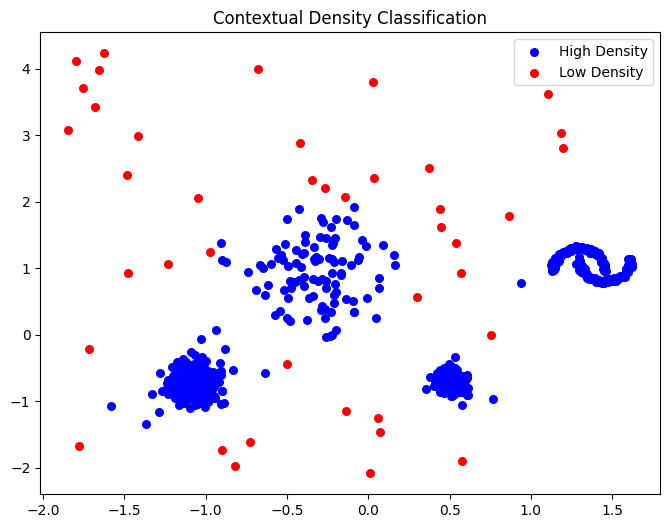

FusedNeighbor merged 33 points into clusters.


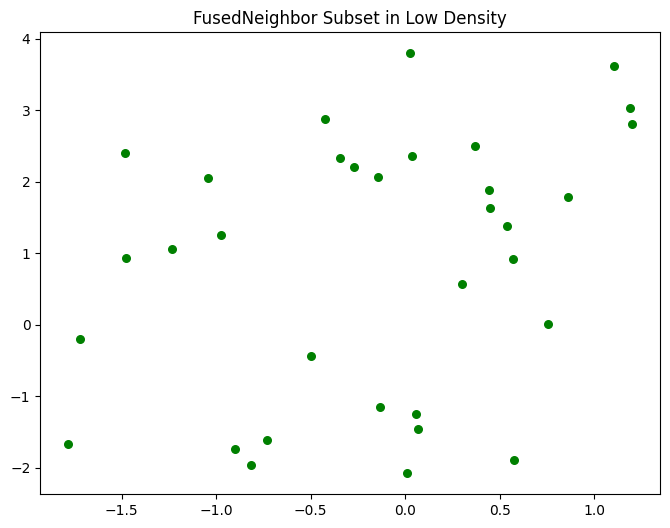

<ipython-input-2-118f5dea9576>:512: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


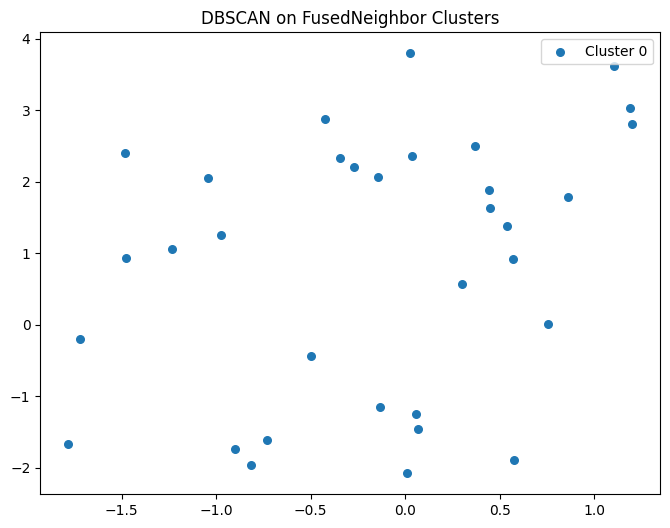

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-2-118f5dea9576>:512: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


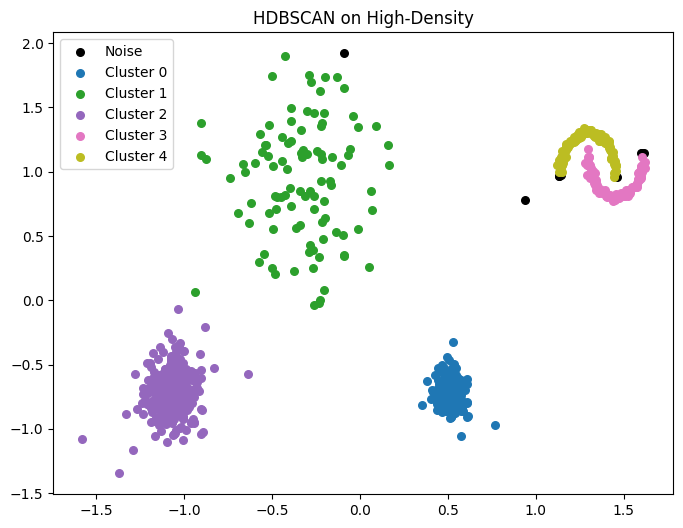

Merged clusters from FusedNeighbor and HDBSCAN.
Assigned outliers to nearest clusters.
Constructed MST on all data.
Scaled MST.
Performed modified cut tree on scaled MST.


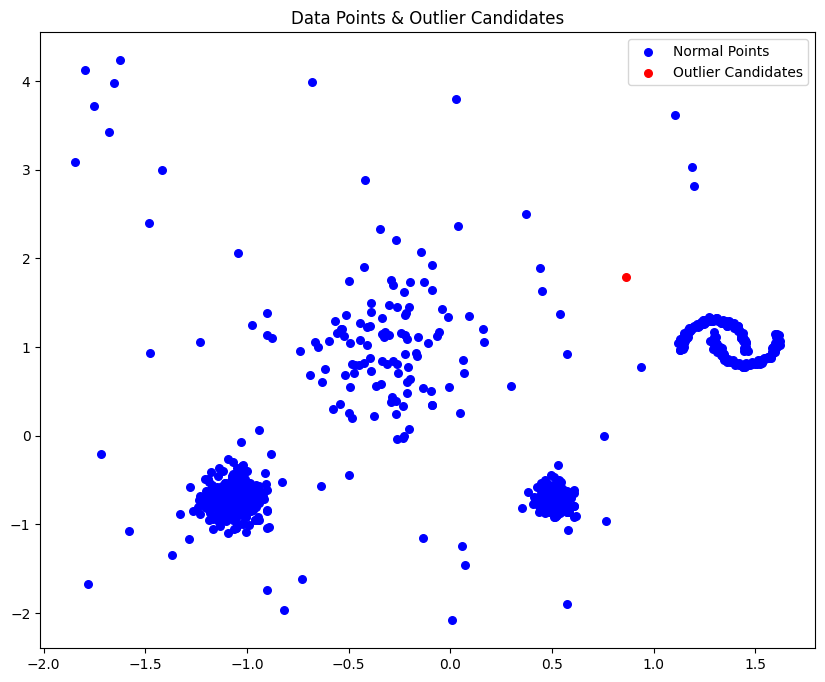

Identified 1 outlier candidates.
Verified and confirmed 0 outliers.


<ipython-input-2-118f5dea9576>:512: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


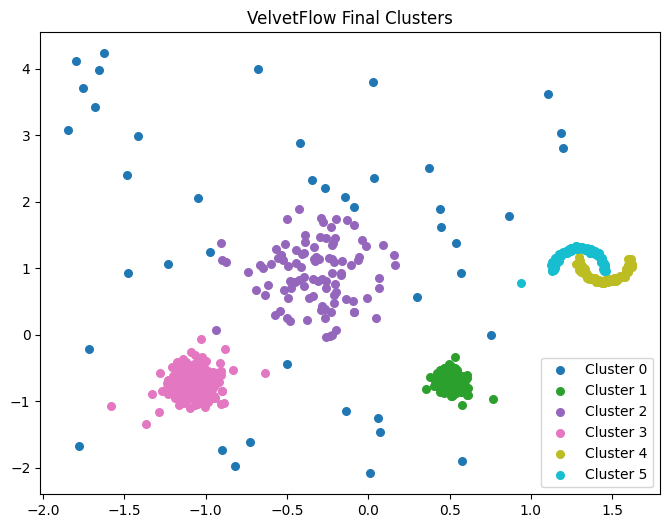

NMI: 0.9523049921113002
ARI: 0.9728926407655382


In [ ]:
# File path to the dataset
file_path = 'synthetic_dataset (3).txt'  # Ensure the dataset has ground truth in the 3rd column
k = 11  # Number of neighbors for relative density calculation                                                  # prev =11
t = 0.038  # Threshold for density classification
eps_fused = 10  # Epsilon parameter for DBSCAN on FusedNeighbor clusters
minpts_fused = 5  # Minimum points for DBSCAN on FusedNeighbor clusters
min_cluster_size_hdbscan = 2  # Minimum cluster size for HDBSCAN
min_samples_hdbscan = 10  # Minimum samples for HDBSCAN

# Run VelvetFlow
new_clusters, X, verified_outliers = velvet_flow(
    file_path=file_path,
    k=k,
    t=t,
    eps_fused=eps_fused,
    minpts_fused=minpts_fused,
    min_cluster_size_hdbscan=min_cluster_size_hdbscan,
    min_samples_hdbscan=min_samples_hdbscan
)

# Prepare cluster dictionary for evaluation
cluster_dict = {}
for idx, label in enumerate(new_clusters):
    if label == -1:  # Ignore noise points
        continue
    cluster_dict.setdefault(label, []).append(idx)

# Compute NMI and ARI
try:
    nmi_score = compute_nmi_with_clusters(cluster_dict, file_path)
    ari_score = compute_ari_with_clusters(cluster_dict, file_path)
    print("NMI:", nmi_score)
    print("ARI:", ari_score)
except Exception as e:
    print("Error computing NMI or ARI:", e)


Loaded dataset with 300 samples.
Computed contextual density.
Classified into 190 high-density and 110 low-density points.


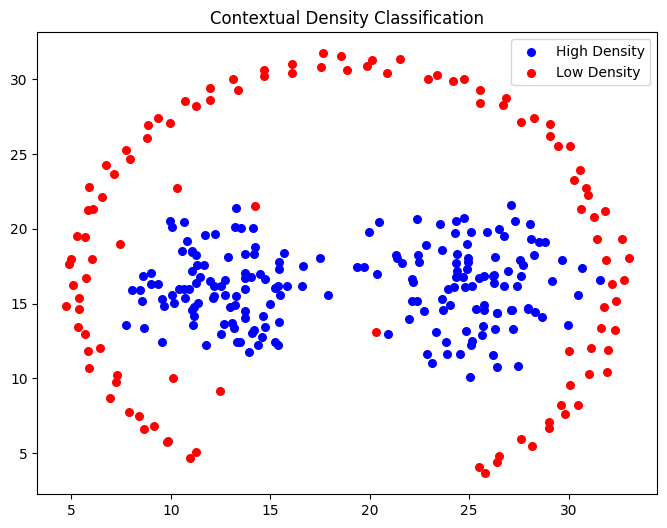

FusedNeighbor merged 63 points into clusters.


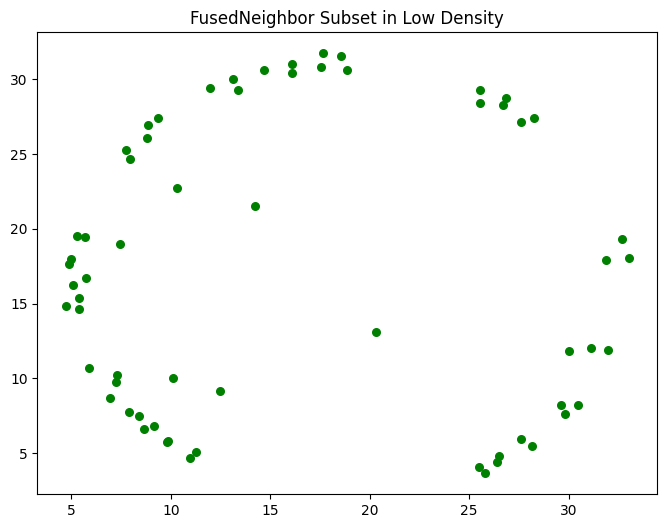

<ipython-input-14-906fbdbe6131>:512: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


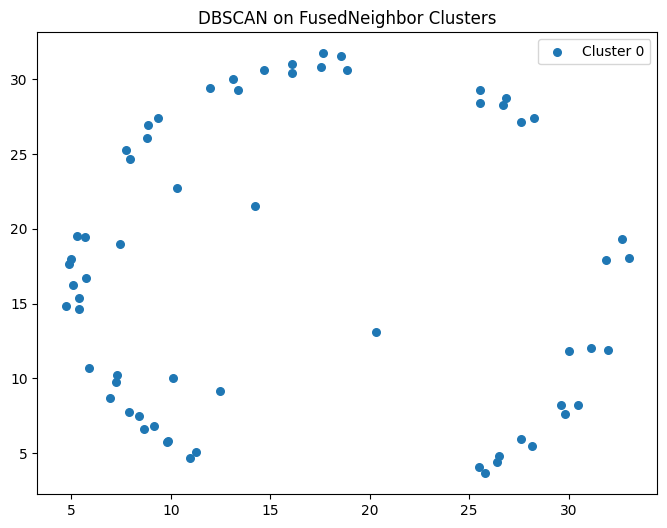

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-14-906fbdbe6131>:512: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


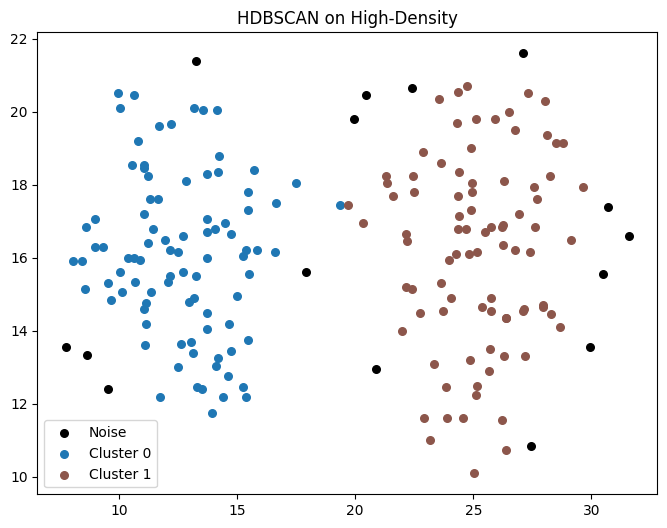

Merged clusters from FusedNeighbor and HDBSCAN.
Assigned outliers to nearest clusters.
Constructed MST on all data.
Scaled MST.
Performed modified cut tree on scaled MST.


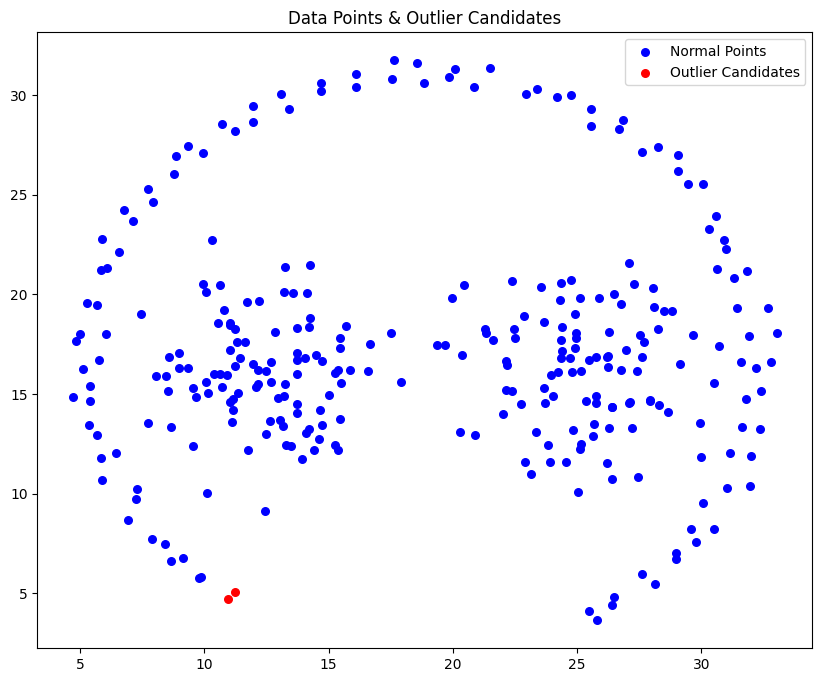

Identified 2 outlier candidates.
Verified and confirmed 0 outliers.


<ipython-input-14-906fbdbe6131>:512: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


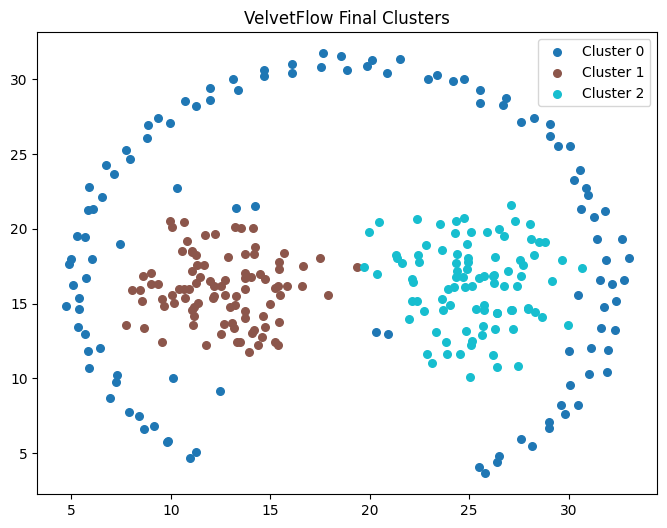

NMI: 0.8510
ARI: 0.8910


In [ ]:
# Import necessary libraries (ensure you include VelvetFlow and required imports above)

# File path to the dataset
file_path = 'pathbased.txt'  # Ensure the dataset has ground truth in the 3rd column
k = 11  # Number of neighbors for relative density calculation
t = 0.27  # Threshold for density classification
eps_fused = 10  # Epsilon parameter for DBSCAN on FusedNeighbor clusters
minpts_fused = 5  # Minimum points for DBSCAN on FusedNeighbor clusters
min_cluster_size_hdbscan = 10  # Minimum cluster size for HDBSCAN
min_samples_hdbscan = 5  # Minimum samples for HDBSCAN

# Run VelvetFlow
new_labels, X, verified_outliers = velvet_flow(
    file_path=file_path,
    k=k,
    t=t,
    eps_fused=eps_fused,
    minpts_fused=minpts_fused,
    min_cluster_size_hdbscan=min_cluster_size_hdbscan,
    min_samples_hdbscan=min_samples_hdbscan
)

# Prepare cluster dictionary from final labels
cluster_dict = {}
for idx, label in enumerate(new_labels):
    if label == -1:  # Skip noise points
        continue
    cluster_dict.setdefault(label, []).append(idx)

# Load ground truth labels
def load_ground_truth(file_path):
    """
    Load ground truth labels from the 3rd column of the dataset.
    """
    data = np.loadtxt(file_path)
    if data.ndim == 1:
        return np.array([int(data[2])])  # For single point dataset
    return data[:, 2].astype(int)

y_true = load_ground_truth(file_path)
n_samples = len(y_true)

# Prepare predicted labels array from cluster dictionary
y_pred = np.full(n_samples, -1, dtype=int)
for cluster_label, indices in cluster_dict.items():
    for idx in indices:
        if idx >= n_samples:
            print(f"Warning: Index {idx} out of bounds for ground truth with size {n_samples}. Skipping.")
            continue
        y_pred[idx] = cluster_label

# Ensure predicted labels match dataset size
if len(y_true) != len(y_pred):
    raise ValueError(f"Size mismatch: y_true has {len(y_true)} samples, but y_pred has {len(y_pred)} labels.")

# Align predicted labels with ground truth using Hungarian Algorithm
def align_labels(true_labels, pred_labels):
    """
    Aligns predicted labels to ground truth labels using the Hungarian algorithm.
    """
    # Create confusion matrix
    confusion_matrix = np.zeros((np.max(true_labels) + 1, np.max(pred_labels) + 1), dtype=int)
    for t, p in zip(true_labels, pred_labels):
        if t != -1 and p != -1:  # Ignore noise points
            confusion_matrix[t, p] += 1

    # Perform Hungarian algorithm for label alignment
    from scipy.optimize import linear_sum_assignment
    row_ind, col_ind = linear_sum_assignment(-confusion_matrix)  # Maximize matches

    # Create mapping from predicted to true labels
    mapping = {pred: true for true, pred in zip(row_ind, col_ind)}

    # Apply mapping to align predicted labels
    aligned_labels = np.array([mapping.get(p, p) for p in pred_labels])
    return aligned_labels

y_pred_aligned = align_labels(y_true, y_pred)

# Compute NMI and ARI scores
try:
    nmi_score = normalized_mutual_info_score(y_true, y_pred_aligned, average_method='arithmetic')
    ari_score = adjusted_rand_score(y_true, y_pred_aligned)
    print(f"NMI: {nmi_score:.4f}")
    print(f"ARI: {ari_score:.4f}")
except Exception as e:
    print(f"Error computing NMI or ARI: {e}")


Loaded dataset with 401 samples.
Computed contextual density.
Classified into 349 high-density and 52 low-density points.


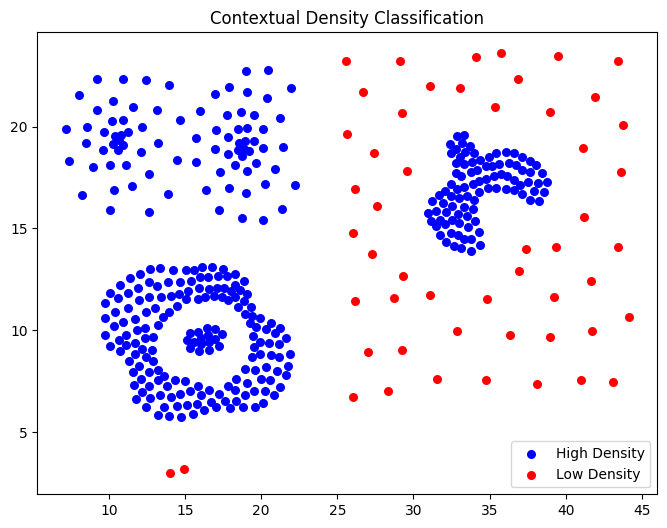

FusedNeighbor merged 39 points into clusters.


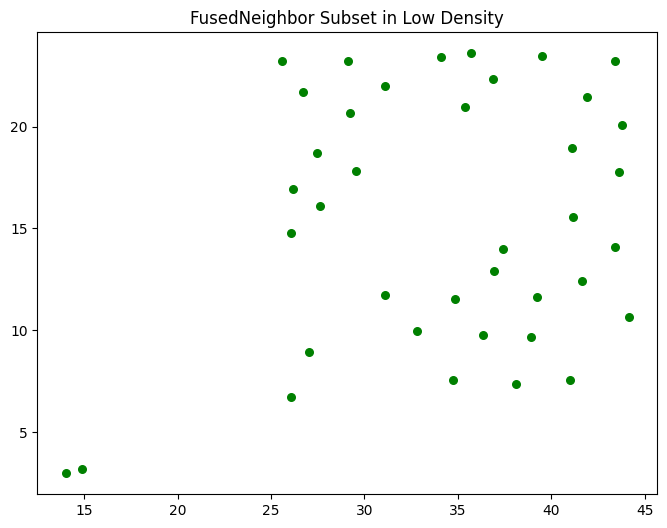

<ipython-input-5-118f5dea9576>:512: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


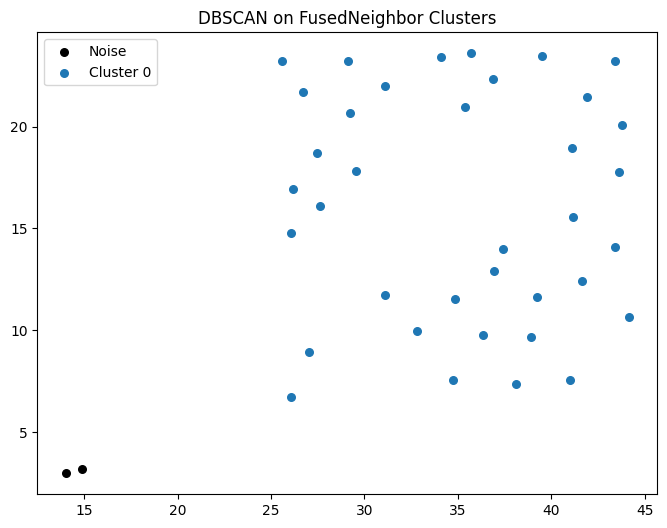

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-5-118f5dea9576>:512: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


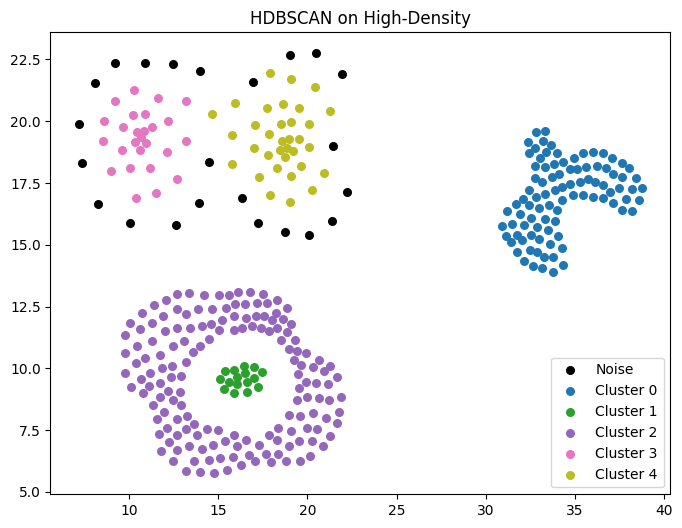

Merged clusters from FusedNeighbor and HDBSCAN.
Assigned outliers to nearest clusters.
Constructed MST on all data.
Scaled MST.
Performed modified cut tree on scaled MST.


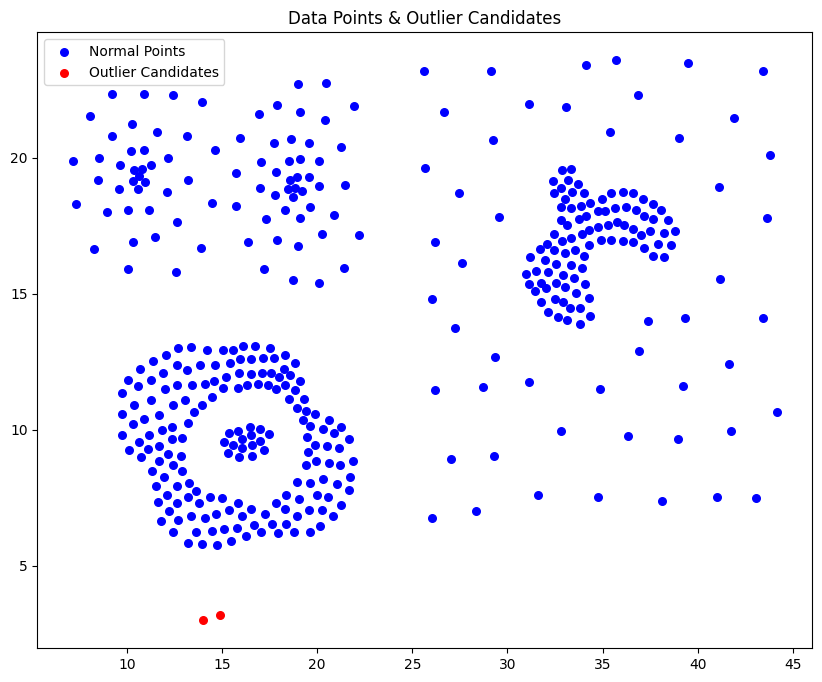

Identified 2 outlier candidates.
Verified outlier: Index 399 in cluster 3, k-NN distance=2.56
Verified outlier: Index 400 in cluster 3, k-NN distance=2.43
Verified and confirmed 2 outliers.


<ipython-input-5-118f5dea9576>:512: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


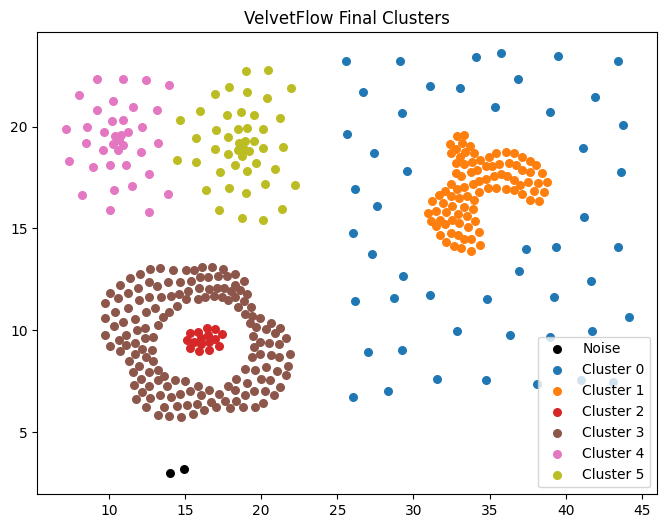

NMI: 0.9925853224804095
ARI: 0.9972346478703771


In [ ]:
if __name__ == "__main__":
    dataset_address = 'Compound_fixed.txt'  # Replace with your dataset path

    # Parameters
    k = 4  # Number of neighbors for relative density
    t = 0.1  # Threshold for density classification
    eps_fused = 5  # DBSCAN epsilon for FusedNeighbor clusters
    minpts_fused = 3  # DBSCAN minPts for FusedNeighbor clusters
    min_cluster_size_hdbscan = 10  # HDBSCAN min_cluster_size
    min_samples_hdbscan = 5  # HDBSCAN min_samples

    # Run VelvetFlow
    new_labels, X, verified_outliers = velvet_flow(
        file_path=dataset_address,
        k=k,
        t=t,
        eps_fused=eps_fused,
        minpts_fused=minpts_fused,
        min_cluster_size_hdbscan=min_cluster_size_hdbscan,
        min_samples_hdbscan=min_samples_hdbscan
    )

    # Prepare cluster dictionary
    cluster_dict = {}
    for idx, label in enumerate(new_labels):
        if label == -1:
            continue
        cluster_dict.setdefault(label, []).append(idx)

    # Load ground truth labels
    def load_ground_truth(file_path):
        data = np.loadtxt(file_path)
        if data.ndim == 1:
            # Only one data point
            return np.array([int(data[2])])
        return data[:, 2].astype(int)

    y_true = load_ground_truth(dataset_address)
    n = len(y_true)

    # Prepare y_pred for alignment
    y_pred = np.full(n, -1, dtype=int)

    for c_label, idxs in cluster_dict.items():
        for idx in idxs:
            if idx >= n:
                print(f"Warning: Index {idx} is out of bounds for y_true with size {n}. Skipping.")
                continue
            y_pred[idx] = c_label

    # Check if y_pred has correct length
    if len(y_true) != len(y_pred):
        raise ValueError(f"Size mismatch: y_true has {len(y_true)} samples, but y_pred has {len(y_pred)} labels.")

    # Align labels
    y_pred_aligned = align_labels(y_true, y_pred)

    # Compute NMI and ARI
    try:
        nmi_score = normalized_mutual_info_score(y_true, y_pred_aligned, average_method='arithmetic')
        ari_score = adjusted_rand_score(y_true, y_pred_aligned)
        print("NMI:", nmi_score)
        print("ARI:", ari_score)
    except Exception as e:
        print("Error computing NMI or ARI:", e)

Loaded dataset with 373 samples.
Computed contextual density.
Classified into 276 high-density and 97 low-density points.


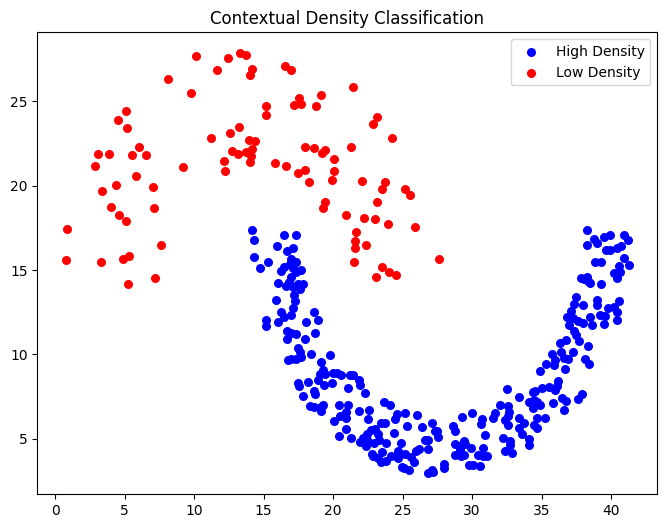

FusedNeighbor merged 73 points into clusters.


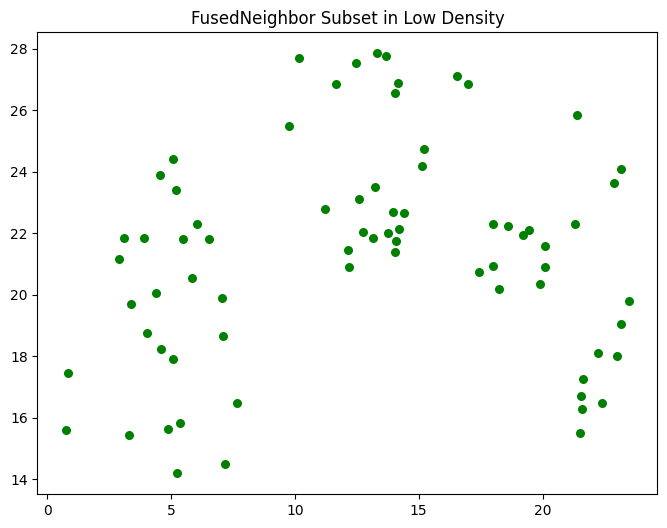

<ipython-input-10-e37760149c9a>:512: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


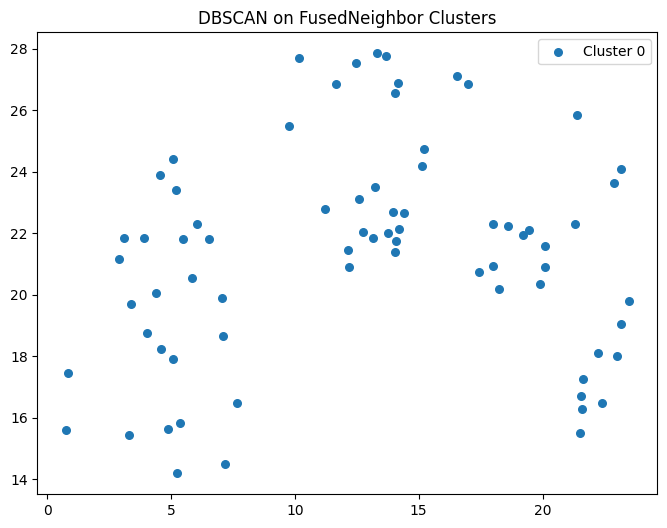

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-10-e37760149c9a>:512: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


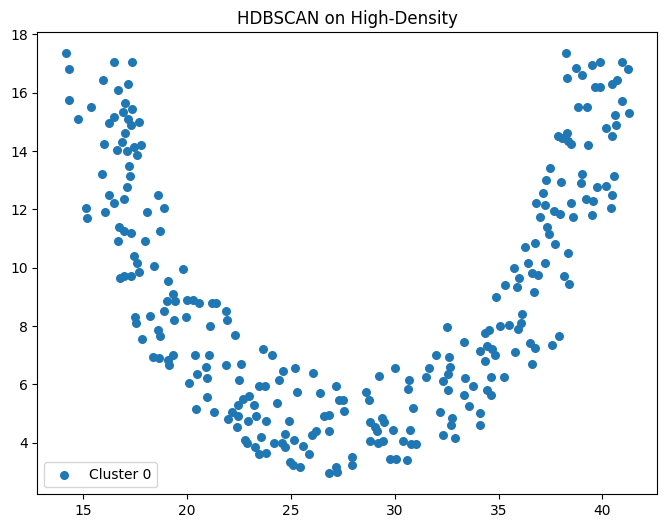

Merged clusters from FusedNeighbor and HDBSCAN.
Assigned outliers to nearest clusters.
Constructed MST on all data.
Scaled MST.
Performed modified cut tree on scaled MST.


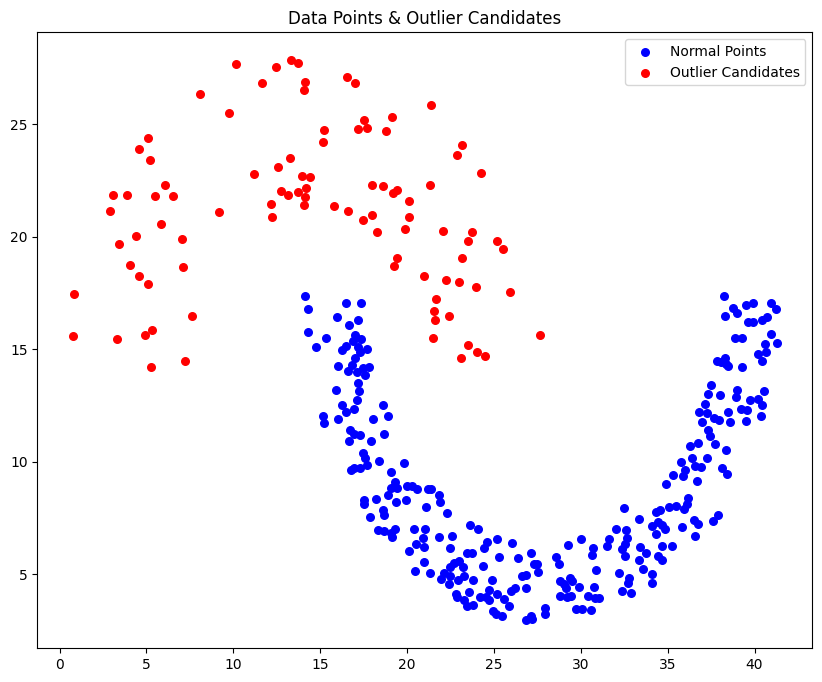

Identified 97 outlier candidates.
Verified outlier: Index 1 in cluster 0, k-NN distance=3.55
Verified outlier: Index 92 in cluster 0, k-NN distance=3.60
Verified and confirmed 2 outliers.


<ipython-input-10-e37760149c9a>:512: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


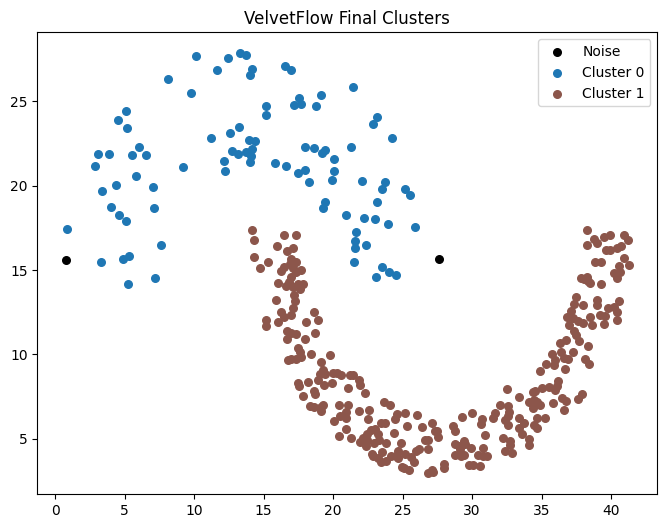

Normalized Mutual Information (NMI): 0.9777207691907807
Adjusted Rand Index (ARI): 0.9942293935989059


In [ ]:
if __name__ == "__main__":
    # Dataset path
    dataset_address = 'jain.txt'  # Replace with your dataset file

    # VelvetFlow parameters
    k = 16  # Number of neighbors for relative density
    t = 0.3  # Threshold for density classification
    eps_fused = 200  # DBSCAN epsilon for FusedNeighbor clusters
    minpts_fused = 3  # DBSCAN minPts for FusedNeighbor clusters
    min_cluster_size_hdbscan = 125  # HDBSCAN min_cluster_size
    min_samples_hdbscan = 1  # HDBSCAN min_samples

    # Run VelvetFlow algorithm
    new_clusters, X, verified_outliers = velvet_flow(
        file_path=dataset_address,
        k=k,
        t=t,
        eps_fused=eps_fused,
        cluster_selection_epsilon=9999,
        minpts_fused=minpts_fused,
        min_cluster_size_hdbscan=min_cluster_size_hdbscan,
        min_samples_hdbscan=min_samples_hdbscan
    )

    # Build cluster dictionary for NMI and ARI evaluation
    cluster_dict = {}
    for idx, label in enumerate(new_clusters):
        if label == -1:  # Exclude noise points
            continue
        cluster_dict.setdefault(label, []).append(idx)

    # Compute NMI and ARI metrics
    try:
        nmi_score = compute_nmi_with_clusters(cluster_dict, dataset_address)
        ari_score = compute_ari_with_clusters(cluster_dict, dataset_address)
        print("Normalized Mutual Information (NMI):", nmi_score)
        print("Adjusted Rand Index (ARI):", ari_score)
    except Exception as e:
        print("Error computing NMI or ARI:", e)
